In [3]:
# Step 1: Environment setup
!pip install --quiet torch torchvision torchaudio matplotlib

import sys, random, os, math
import numpy as np
import torch

# reproducibility
SEED = 42
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(SEED)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Python:", sys.version.splitlines()[0])
print("PyTorch:", torch.__version__)
print("Device:", device)
if device.type == "cuda":
    try:
        print("GPU:", torch.cuda.get_device_name(0),
              "Memory(GB):", round(torch.cuda.get_device_properties(0).total_memory/1024**3,2))
    except:
        pass

Python: 3.12.12 (main, Oct 10 2025, 08:52:57) [GCC 11.4.0]
PyTorch: 2.8.0+cu126
Device: cuda
GPU: Tesla T4 Memory(GB): 14.74


In [4]:
# Step 2: Upload and clean the Pride & Prejudice text
from google.colab import files
import re

print("Upload the provided Pride_and_Prejudice txt file (Project Gutenberg) ...")
uploaded = files.upload()
filename = list(uploaded.keys())[0]
print("Uploaded:", filename)

with open(filename, "r", encoding="utf-8", errors="ignore") as f:
    raw = f.read()

lower = raw.lower()

# find story start using canonical phrase
start_phrase = "it is a truth universally acknowledged"
s = lower.find(start_phrase)
if s == -1:
    raise RuntimeError("Could not find story start phrase.")

# find story end using candidate phrases
end_candidates = ["darcy as to be sensible of your kindness", "darcy, as to be sensible of your kindness", "the end"]
e = -1
for cand in end_candidates:
    pos = lower.rfind(cand)
    if pos != -1:
        e = pos + len(cand)
        break
if e == -1:
    e = len(raw)

clean_text = raw[s:e].strip().lower()

# save cleaned file (deliverable)
os.makedirs("data", exist_ok=True)
clean_fn = "data/Pride_and_Prejudice_CLEANED.txt"
with open(clean_fn, "w", encoding="utf-8") as f:
    f.write(clean_text)

print("Cleaned text saved to", clean_fn)
print("Preview:\n")
print(clean_text[:500])
print("\nLength:", len(clean_text))

Upload the provided Pride_and_Prejudice txt file (Project Gutenberg) ...


Saving Pride_and_Prejudice-Jane_Austen.txt to Pride_and_Prejudice-Jane_Austen.txt
Uploaded: Pride_and_Prejudice-Jane_Austen.txt
Cleaned text saved to data/Pride_and_Prejudice_CLEANED.txt
Preview:

it is a truth universally acknowledged, that a single man in possession
of a good fortune, must be in want of a wife.

however little known the feelings or views of such a man may be on his
first entering a neighbourhood, this truth is so well fixed in the minds
of the surrounding families, that he is considered as the rightful
property of some one or other of their daughters.

"my dear mr. bennet," said his lady to him one day, "have you heard that
netherfield park is let at last?"

mr. bennet 

Length: 615927


In [5]:
# Step 3: Build character vocabulary and encode
chars = sorted(list(set(clean_text)))
vocab_size = len(chars)
print("Unique characters:", vocab_size)
print("Sample chars:", chars[:30], " ...")

char_to_int = {c:i for i,c in enumerate(chars)}
int_to_char = {i:c for c,i in char_to_int.items()}

encoded_text = [char_to_int[c] for c in clean_text]
print("Encoded text length:", len(encoded_text))
print("Example encoded (first 20):", encoded_text[:20])

Unique characters: 53
Sample chars: ['\n', ' ', '!', '"', '&', "'", '(', ')', '*', ',', '-', '.', '1', '2', '3', '4', '5', '6', '8', ':', ';', '?', '[', ']', '_', 'a', 'b', 'c', 'd', 'e']  ...
Encoded text length: 615927
Example encoded (first 20): [33, 44, 1, 33, 43, 1, 25, 1, 44, 42, 45, 44, 32, 1, 45, 38, 33, 46, 29, 42]


In [6]:
# Step 4: Create sequences and DataLoader
import torch
from torch.utils.data import Dataset, DataLoader

SEQ_LEN = 100
X, Y = [], []
for i in range(len(encoded_text) - SEQ_LEN):
    X.append(encoded_text[i:i+SEQ_LEN])
    Y.append(encoded_text[i+SEQ_LEN])

print("Total sequences:", len(X))

split = int(0.9 * len(X))
X_train, Y_train = X[:split], Y[:split]
X_val, Y_val = X[split:], Y[split:]

print("Train sequences:", len(X_train))
print("Val sequences:", len(X_val))

class CharDataset(Dataset):
    def __init__(self, X, Y):
        self.X = X; self.Y = Y
    def __len__(self): return len(self.X)
    def __getitem__(self, idx):
        return torch.tensor(self.X[idx], dtype=torch.long), torch.tensor(self.Y[idx], dtype=torch.long)

BATCH_SIZE = 128
train_loader = DataLoader(CharDataset(X_train, Y_train), batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(CharDataset(X_val, Y_val), batch_size=BATCH_SIZE, shuffle=False)

xb, yb = next(iter(train_loader))
print("Batch shapes:", xb.shape, yb.shape)

Total sequences: 615827
Train sequences: 554244
Val sequences: 61583
Batch shapes: torch.Size([128, 100]) torch.Size([128])


In [7]:
# Step 5: A simple 1-layer LSTM model
import torch.nn as nn

class SimpleLSTM(nn.Module):
    def __init__(self, vocab_size, embed_size=64, hidden_size=128):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, embed_size)
        self.lstm = nn.LSTM(embed_size, hidden_size, batch_first=True)
        self.fc = nn.Linear(hidden_size, vocab_size)
    def forward(self, x):
        x = self.embedding(x)              # (batch, seq, emb)
        out, _ = self.lstm(x)              # (batch, seq, hidden)
        out = out[:, -1, :]                # (batch, hidden)
        logits = self.fc(out)              # (batch, vocab)
        return logits

# instantiate best-fit model
best_model = SimpleLSTM(vocab_size, embed_size=64, hidden_size=128).to(device)
print(best_model)

SimpleLSTM(
  (embedding): Embedding(53, 64)
  (lstm): LSTM(64, 128, batch_first=True)
  (fc): Linear(in_features=128, out_features=53, bias=True)
)


In [8]:
# Step 6: Simple training + validation function
import torch.optim as optim
import math
criterion = nn.CrossEntropyLoss()

def perplexity(loss):
    return math.exp(loss)

def train_model(model, train_loader, val_loader, epochs=5, lr=0.001):
    optimizer = optim.Adam(model.parameters(), lr=lr)
    train_losses, val_losses = [], []
    for epoch in range(1, epochs+1):
        # train
        model.train()
        total_train = 0.0
        for xb, yb in train_loader:
            xb, yb = xb.to(device), yb.to(device)
            optimizer.zero_grad()
            logits = model(xb)
            loss = criterion(logits, yb)
            loss.backward()
            optimizer.step()
            total_train += loss.item()
        avg_train = total_train / len(train_loader)
        train_losses.append(avg_train)

        # val
        model.eval()
        total_val = 0.0
        with torch.no_grad():
            for xb, yb in val_loader:
                xb, yb = xb.to(device), yb.to(device)
                logits = model(xb)
                loss = criterion(logits, yb)
                total_val += loss.item()
        avg_val = total_val / len(val_loader)
        val_losses.append(avg_val)

        print(f"Epoch {epoch}/{epochs} | Train Loss: {avg_train:.4f} | Val Loss: {avg_val:.4f} | Val PPL: {perplexity(avg_val):.2f}")
    return train_losses, val_losses

In [9]:
# Step 7: Train best-fit model
best_train_losses, best_val_losses = train_model(
    best_model,
    train_loader,
    val_loader,
    epochs=5,
    lr=0.001
)

Epoch 1/5 | Train Loss: 1.8404 | Val Loss: 1.5617 | Val PPL: 4.77
Epoch 2/5 | Train Loss: 1.4795 | Val Loss: 1.4227 | Val PPL: 4.15
Epoch 3/5 | Train Loss: 1.3770 | Val Loss: 1.3673 | Val PPL: 3.92
Epoch 4/5 | Train Loss: 1.3234 | Val Loss: 1.3290 | Val PPL: 3.78
Epoch 5/5 | Train Loss: 1.2884 | Val Loss: 1.3081 | Val PPL: 3.70


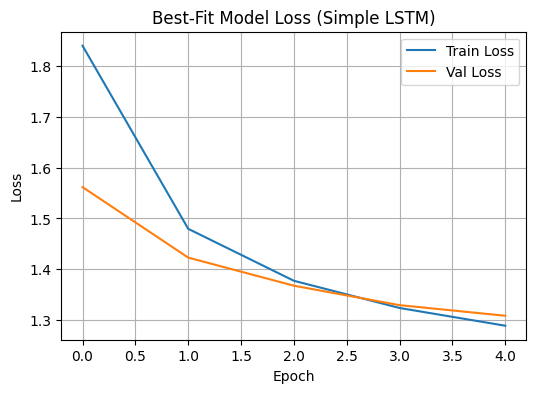

Saved: plots/bestfit_loss.png


In [10]:
# Plot and save best-fit loss curve
import matplotlib.pyplot as plt
os.makedirs("plots", exist_ok=True)

plt.figure(figsize=(6,4))
plt.plot(best_train_losses, label='Train Loss')
plt.plot(best_val_losses, label='Val Loss')
plt.title('Best-Fit Model Loss (Simple LSTM)')
plt.xlabel('Epoch'); plt.ylabel('Loss'); plt.legend(); plt.grid(True)
plt.savefig("plots/bestfit_loss.png", dpi=150, bbox_inches='tight')
plt.show()
print("Saved: plots/bestfit_loss.png")

Underfitting model: SimpleLSTM(
  (embedding): Embedding(53, 16)
  (lstm): LSTM(16, 32, batch_first=True)
  (fc): Linear(in_features=32, out_features=53, bias=True)
)
Epoch 1/3 | Train Loss: 2.3369 | Val Loss: 2.0586 | Val PPL: 7.84
Epoch 2/3 | Train Loss: 1.9815 | Val Loss: 1.9090 | Val PPL: 6.75
Epoch 3/3 | Train Loss: 1.8789 | Val Loss: 1.8368 | Val PPL: 6.28


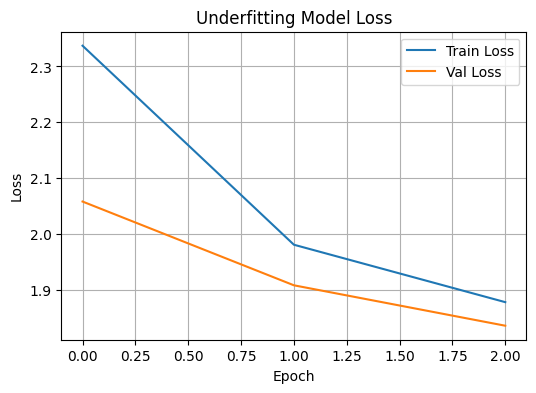

Saved: plots/underfit_loss.png


In [11]:
# Step 8: Underfitting experiment
under_model = SimpleLSTM(vocab_size, embed_size=16, hidden_size=32).to(device)
print("Underfitting model:", under_model)
under_train_losses, under_val_losses = train_model(under_model, train_loader, val_loader, epochs=3, lr=0.001)
# plot and save
plt.figure(figsize=(6,4))
plt.plot(under_train_losses, label='Train Loss')
plt.plot(under_val_losses, label='Val Loss')
plt.title('Underfitting Model Loss')
plt.xlabel('Epoch'); plt.ylabel('Loss'); plt.legend(); plt.grid(True)
plt.savefig("plots/underfit_loss.png", dpi=150, bbox_inches='tight')
plt.show()
print("Saved: plots/underfit_loss.png")

Small subset size: 1000
Overfitting model: SimpleLSTM(
  (embedding): Embedding(53, 128)
  (lstm): LSTM(128, 256, batch_first=True)
  (fc): Linear(in_features=256, out_features=53, bias=True)
)
Epoch 1/7 | Train Loss: 3.1155 | Val Loss: 2.7430 | Val PPL: 15.53
Epoch 2/7 | Train Loss: 2.4140 | Val Loss: 2.5975 | Val PPL: 13.43
Epoch 3/7 | Train Loss: 2.0944 | Val Loss: 2.5623 | Val PPL: 12.97
Epoch 4/7 | Train Loss: 1.8231 | Val Loss: 2.5836 | Val PPL: 13.24
Epoch 5/7 | Train Loss: 1.5894 | Val Loss: 2.6348 | Val PPL: 13.94
Epoch 6/7 | Train Loss: 1.3344 | Val Loss: 2.6859 | Val PPL: 14.67
Epoch 7/7 | Train Loss: 1.0993 | Val Loss: 2.7902 | Val PPL: 16.28


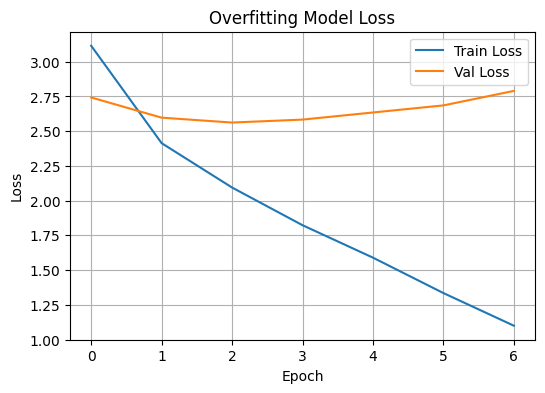

Saved: plots/overfit_loss.png


In [12]:
# Step 9: Overfitting experiment
# Make small subset (1000 sequences)
small_X = X_train[:1000]; small_Y = Y_train[:1000]
small_loader = DataLoader(CharDataset(small_X, small_Y), batch_size=128, shuffle=True)
print("Small subset size:", len(small_X))

over_model = SimpleLSTM(vocab_size, embed_size=128, hidden_size=256).to(device)
print("Overfitting model:", over_model)

over_train_losses, over_val_losses = train_model(over_model, small_loader, val_loader, epochs=7, lr=0.01)

# plot and save
plt.figure(figsize=(6,4))
plt.plot(over_train_losses, label='Train Loss')
plt.plot(over_val_losses, label='Val Loss')
plt.title('Overfitting Model Loss')
plt.xlabel('Epoch'); plt.ylabel('Loss'); plt.legend(); plt.grid(True)
plt.savefig("plots/overfit_loss.png", dpi=150, bbox_inches='tight')
plt.show()
print("Saved: plots/overfit_loss.png")

In [13]:
# Step 10: Save trained models (deliverables)
os.makedirs("models", exist_ok=True)
torch.save(best_model.state_dict(), "models/bestfit_model.pt")
torch.save(under_model.state_dict(), "models/underfit_model.pt")
torch.save(over_model.state_dict(), "models/overfit_model.pt")
print("Saved models to models/*.pt")

Saved models to models/*.pt


In [14]:
# Step 11: Print a small summary table with final metrics
def final_ppl(val_losses):
    return math.exp(val_losses[-1])

print("FINAL METRICS:")
print("Best-fit Val Loss:", best_val_losses[-1], "PPL:", final_ppl(best_val_losses))
print("Underfit Val Loss:", under_val_losses[-1], "PPL:", final_ppl(under_val_losses))
print("Overfit Val Loss:", over_val_losses[-1], "PPL:", final_ppl(over_val_losses))

FINAL METRICS:
Best-fit Val Loss: 1.3080846041564624 PPL: 3.6990817166440424
Underfit Val Loss: 1.836823807217768 PPL: 6.276570968420433
Overfit Val Loss: 2.79021733282018 PPL: 16.284558586270435
